In [1]:
from flax import linen as nn
from jax import numpy as jnp
import jax
import optax
from clu import parameter_overview
from flax import struct
from clu import metrics
from flax.training import train_state

2023-08-08 19:53:55.044822: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Config

In [2]:
import datetime

import ml_collections


def get_config():
    """Get the default hyperparameter configuration."""
    
    datetime_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    
    config = ml_collections.ConfigDict()
    # Which fragment of the MovieLens dataset to evaluate on.
    # latest-small-ratings 
    # 100k-ratings
    # 1m-ratings
    # 20m-ratings
    # 25m-ratings
    config.ds_name = '1m-ratings'
    # The number of users to take the last review from for evaluation.
    config.eval_users_count = 1000
    
    # Top level random seed which cannot be 0.
    config.seed = 7
    
    # Model Parameters.
    config.learning_rate = 0.003
    config.features_dim = 64
    config.batch_size = 64
    config.num_epochs = 100

    return config

# Data

In [3]:
import abc
import itertools
from typing import Iterable, Mapping, Optional, Sequence, Tuple, Union

import dataclasses
from jax import numpy as jnp
from jax import random
import pandas as pd
import tensorflow as tf


@dataclasses.dataclass
class Datasets():
  """A Wrapper for a Recommender dataset.

  Contains:
    - The train and eval datasets with dense IDs.
    - The train and eval set sizes.
    - The relationship between the original IDs and the dense IDs.

  User and Item IDs from the original namespace corresponding to their dense
  indexes according to where they are in users/items list:
    users[i] = original user ID of dense user id i,
    items[j] = original item ID of dense item id j.

  Attributes:
    train: The training dataset.
    eval: The evaluation dataset.
    users: A sequence of all user IDs.
    items: A sequence of all item IDs.
    num_train: The number of examples in `train`.
    num_eval: The number of examples in `eval`.
  """
  # TODO(b/193004520): Rewrite as a single TFDS dataset with splits. See:
  #  https://www.tensorflow.org/datasets/add_dataset
  # Consider inheriting from `tfds.core.GeneratorBasedBuilder`
  # and writing the _split_generators method (using the below implementation)
  train: tf.data.Dataset
  eval: tf.data.Dataset
  users: Sequence[str]
  items: Sequence[str]
  num_train: int
  num_eval: int


class DatasetsBuilder(abc.ABCMeta):
  """Interface for dataset builders.

  This class implements an interface for building datasets in
  jax_recommenders. Classes inheriting it must implement function
  `load_data_as_dataframe`. This class also implements several helpful
  functions to simplify the process of dataset implementation.

  Example:
    class RealDataset(dataset_utils.DatasetsBuilder):
      fields = {
          ('item_id', tf.int32),
          ('user_id', tf.int32),
          ('choice_delay', tf.float32),
          ('time_delta', tf.int32),
          ('user_rating', tf.float32),
      }

      @classmethod
      def load_data_as_dataframe(cls,
                                 tfds_name: str = 'latest-small-ratings',
                                 ) -> pd.DataFrame:
          return pd.read_csv('dataset.csv')
  """

  fields = {
      ('item_id', tf.int32),
      ('timestamp', tf.int32),
      ('user_id', tf.int32),
      ('user_rating', tf.float32),
      # Note that is_first has a value 1 for true, and a value 0 for false.
      ('is_first', tf.int32),
      ('time_delta', tf.int32),
  }

  # Important fields for building the dataset
  USER_ID = 'user_id'
  ITEM_ID = 'item_id'
  TIMESTAMP = 'timestamp'
  USER_RATING = 'user_rating'
  IS_FIRST = 'is_first'
  TIME_DELTA = 'time_delta'

  @classmethod
  def prepare_datasets(cls,
                       tfds_name: str = 'latest-small-ratings',
                       eval_users_count: int = 500,
                       rng: Optional[jnp.ndarray] = None,
                       random_seed: Optional[int] = None,
                       ) -> Datasets:
    """Prepares datasets for Recommender training and eval.

    This function should be implemented by child dataset builders. This function
    should load and split the dataset into train and eval. The eval subset is
    based on the most recent review of a random sample of users.

    Args:
      tfds_name: The dataset name in tensorflow, if inherited from there.
      eval_users_count: The number of eval users to include.
      rng: An optional random number generator to use for the split. If not
        provided, uses the `random_seed` argument.
      random_seed: An optional random seed integer to use if rng is not
        specified.

    Returns:
      A Datasets object with the train and eval splits.
    """
    if rng is None and random_seed is None:
      raise ValueError('At least one of rng or random_seed must be defined.')
    if rng is None:
      rng = random.PRNGKey(random_seed)

    reviews_df = cls.load_data_as_dataframe(tfds_name)
    return cls.make_datasets_from_reviews_dataframe(
        reviews_df, eval_users_count, rng)

  @classmethod
  @abc.abstractmethod
  def load_data_as_dataframe(cls,
                             tfds_name: str = 'latest-small-ratings',
                             eval_users_count: int = 500,
                             rng: Optional[jnp.ndarray] = None,
                             random_seed: Optional[int] = None,
                             ) -> pd.DataFrame:
    """Prepares datasets for Recommender training and eval.

    This function should be implemented by child dataset builders. This function
    should load and split the dataset into train and eval. The eval subset is
    based on the most recent review of a random sample of users.

    Args:
      tfds_name: The dataset name in tensorflow, if inherited from there.
      eval_users_count: The number of eval users to include.
      rng: An optional random number generator to use for the split. If not
        provided, uses the `random_seed` argument.
      random_seed: An optional random seed integer to use if rng is not
        specified.

    Returns:
      A Datasets object with the train and eval splits.
    """
    pass

  @classmethod
  def _create_tfds_from_df(cls, df: pd.DataFrame) -> tf.data.Dataset:
    tensor_slices = {
        field: tf.cast(df[field].values, dtype=field_type)
        for field, field_type in cls.fields
    }

    return tf.data.Dataset.from_tensor_slices(tensor_slices)

  @staticmethod
  def create_dense_map(id_set: Iterable[str]) -> Mapping[str, int]:
    """Creates a dense mapping from elements of id_set to integers."""
    return {id_str: i for (i, id_str) in enumerate(id_set)}

  @classmethod
  def densify_column_values(
      cls,
      df: pd.DataFrame,
      col_name: str
  ) -> Tuple[pd.Series, Sequence[str]]:
    col_values = sorted(set(df[col_name]))
    col_ids_map = cls.create_dense_map(col_values)
    return df[col_name].apply(lambda col_id: col_ids_map[col_id]), col_values

  @staticmethod
  def time_diff(s: Iterable[Union[float, int]]) -> Union[float, int]:
    """Tiny helper to compute time diffs for window size 2 series."""
    first, second = itertools.islice(s, 2)
    return second - first

  @classmethod
  def add_per_user_time_deltas(cls, df: pd.DataFrame) -> pd.DataFrame:
    """Adds time differences between the reviews (rows) in the dataframe.

    Assumes:
      - `df` is sorted by time.
      - The time is specified in the column 'timestamp'.
      - User IDs are in the column 'user_id'.

    When the dataframe contains multiple identical timestamps, the time_delta
    and is_first entry will be the same for all of them.

    Args:
      df: Pandas dataframe. Must have 'user_id' and 'timestamp' columns.

    Returns:
      A new Pandas dataframe based on `df` with the additional columns:
      - 'time_delta': Contains the time since the user's previous entry, and
        is 0 for the user's first entry.
      - 'is_first': Contains 1 for the user's first review (w.r.t. timestamp),
        and is 0 otherwise.

    Raises:
      KeyError: If df is missing the 'user_id' or 'timestamp' column.
    """
    # Add the 'is_first' column.
    min_timestamps_df = df.groupby(cls.USER_ID).agg(min_timestamp=(cls.TIMESTAMP, 'min'))
    with_min_timestamp_df = df.join(min_timestamps_df, on=cls.USER_ID)
    returned_df = df.copy()
    returned_df[cls.IS_FIRST] = (with_min_timestamp_df['min_timestamp'] == with_min_timestamp_df[cls.TIMESTAMP]).apply(int)

    # Add 'time_delta' column.
    user_timestamp_groups = returned_df[[cls.USER_ID, cls.TIMESTAMP]].drop_duplicates()
    # Every initial user's 'time_delta' will be NaN, fillna replaces it with 0.
    time_delta_df = (
        user_timestamp_groups
        .groupby(cls.USER_ID)[cls.TIMESTAMP]
        .rolling(2, min_periods=2)
        .apply(cls.time_diff)
        .fillna(0)
        .to_frame(cls.TIME_DELTA)
    )
    user_timestamp_groups[cls.TIME_DELTA] = time_delta_df.droplevel(cls.USER_ID).sort_index()
    user_timestamp_groups = user_timestamp_groups.set_index([cls.USER_ID, cls.TIMESTAMP])
    returned_df = returned_df.join(user_timestamp_groups, on=[cls.USER_ID, cls.TIMESTAMP])
    # Correct for Pandas bug/oddidty where types get lost and operations often
    # turn integers into floats.
    return returned_df.astype({cls.IS_FIRST: 'int64', cls.TIME_DELTA: 'int64'})

  @classmethod
  def leave_last_one_out_split(
      cls,
      reviews_df: pd.DataFrame,
      eval_user_ids: Iterable[int]
  ) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Splits reviews_df into train and eval splits.

    The eval split is the chronologically last review for each of eval_user_ids.
    When there are two last reviews, the fist one becomes the test review.

    Args:
      reviews_df: Each row is a review (a user and item interaction); it must
        contain a 'user_id' and a 'timestamp' column.
      eval_user_ids: Iterable of user ids that should be in the eval set. These
        must be formatted in the same way as they are in `df` (the '=='
        operation will be applied to filter for entries from a user).

    Returns:
      A pair `(train_df, eval_df)`: `train_df` is a dataframe containing
      training data (all but the last review for eval users, and all reviews for
      other users); `eval_df` is the dataframe containing the last review for
      every eval user.
    """
    # eval_users_set = set(eval_user_ids)
    eval_user_selector = reviews_df[cls.USER_ID].apply(lambda uid: uid in eval_user_ids)
    eval_users_df = reviews_df[eval_user_selector]
    # For each user_id, pick the review with the largest timestamp. Results in a
    # DataFrame where each index corresponds to an index in reviews_df with the
    # largest timestamp for that user.
    user_grouped_timestamps = eval_users_df.groupby([cls.USER_ID])[cls.TIMESTAMP]
    user_last_review_idx = (
        user_grouped_timestamps
        .apply(lambda group: group.nlargest(1))
        .reset_index(level=0, drop=False)
    )
    eval_review_selector = reviews_df.index.isin(user_last_review_idx.index)
    eval_df = reviews_df[eval_review_selector]
    train_df = reviews_df[~eval_review_selector]
    return train_df, eval_df

  @classmethod
  def make_datasets_from_reviews_dataframe(cls,
                                           reviews_df: pd.DataFrame,
                                           eval_users_count: int,
                                           rng: jnp.ndarray) -> Datasets:
    """Creates a Datasets object for a DataFrame of reviews.

    Note: the train and eval datasets have a shared dense ID space for users
    and items.

    Properties:
      - The 'user_id' and 'item_id' columns can contain integers or strings.
      - 'user_id' entries get reindexed to a dense mapping, from 0 to the number
        of user ids.
      - 'item_id' entries get reindexed to a dense mapping, from 0 to the number
        of item ids.
      - 'time_delta' entries get computed and added.
      - 'user_rating' entries get converted to floats.
      - The last time-stamped review for randomly picked set of `user_id`s (the
        size of which is specified by `eval_users_count`) gets turned into the
        eval dataset.

    Args:
      reviews_df: Pandas DataFrame of reviews. Assumes it has columns:
        - 'timestamp': int,
        - 'user_id': int or string,
        - 'item_id': int or string,
        - 'user_rating': int or float.
      eval_users_count: number of users to include in the eval set.
      rng: jax random number generator to select eval users.

    Returns:
      A `Datasets` object for the train/eval split. The eval set has the last
      review for the eval set of users. Given:
        `ds = make_datasets_from_reviews_dataframe(...)`
      Then the following invariants hold:
        - `len(ds.eval) == eval_users_count == ds.num_eval`.
        - `len(ds.eval) + len(ds.train) == len(reviews_df)`.
        - `len(ds.train) == ds.num_train`.
        - `ds.users` is the set of users sorted, the user IDs come from the
          user-representation's sort order List[str].sort() or List[int].sort().
        - `ds.items` is the set of items sorted the same way as ds.users.
        - `ds.eval` and `ds.train` have a 'time_delta' column: it has the time
          difference to the user's previous (by timestamp) review.
        - `ds.eval` and `ds.train` have a 'is_first' column: which is 1 for the
          set of minimal timestamp reviews (typically only one per user, but
          there may be more) and it is 0 for all other reviews.
        - The 'user_rating' column of `ds.eval` and `ds.train` is converted to a
          float.
        - Every review in `ds.eval` is a maximal w.r.t. that user's review
          timestamps.
        - The eval set may contain reviews which have `is_first` = 1 (providing
          constraints for this will happen in a followup CL).

    Raises:
      ValueError: When eval_users_count > the number of users in the dataframe.
    """
    # TODO(b/193004884): Provide a parameter to select users, e.g. only select
    # eval users that have more than some number of past reviews.

    # Sort in ascending order of time (entries earlier in time come first).
    reviews_df = reviews_df.sort_values(cls.TIMESTAMP)
    # Adds deltas between reviews, named 'time_delta'.
    reviews_df = cls.add_per_user_time_deltas(reviews_df)

    # This maps item and user IDs from the original IDs to integer IDs in the
    # range 0 to (num_items - 1) or (num_users - 1 ) respectively. This is so
    # we can access embeddings in a (num_items * embedding_dim) or
    # (num_users * embedding_dim) matrix easily.
    reviews_df[cls.USER_ID], user_list = cls.densify_column_values(reviews_df, cls.USER_ID)
    reviews_df[cls.ITEM_ID], item_list = cls.densify_column_values(reviews_df, cls.ITEM_ID)

    dense_user_list = reviews_df[cls.USER_ID].unique()
    # Raises ValueError if eval_users_count > len(dense_user_list).
    eval_users = list(
        random.choice(
            rng,
            jnp.array(dense_user_list),
            shape=(eval_users_count,),
            replace=False
        )
    )
    eval_users = [i.item() for i in eval_users]

    # Split train and eval.
    # TODO(b/193004524): Support a dev set separate from train and eval.
    train_df, eval_df = cls.leave_last_one_out_split(reviews_df, eval_users)
    ds_train = cls._create_tfds_from_df(train_df)
    ds_eval = cls._create_tfds_from_df(eval_df)

    return Datasets(
        train=ds_train,
        eval=ds_eval,
        users=user_list,
        items=item_list,
        num_train=len(train_df),
        num_eval=len(eval_df))

In [4]:
"""Provides functions to create a recommendation Datasets object for MovieLens.

For more details about the dataset see:
  https://www.tensorflow.org/datasets/catalog/movielens
Note there is an identical duplicate dataset named 'movie_lens', it does not
matter which is used.
"""
from typing import Mapping, Tuple

import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds


class Movielens(DatasetsBuilder):
  """Builder class to create a recommendation Datasets for MovieLens."""

  @staticmethod
  def make_reviews_dataframe(all_movielens_df: pd.DataFrame) -> pd.DataFrame:
    """Makes a generic reviews Pandas DataFrame from a MovieLens DataFrame."""
    # Make named items and users IDs (items are movies).
    all_movielens_df['item_id'] = all_movielens_df['movie_id'].apply(
        lambda b: f'ml_mid_{b}')
    all_movielens_df['user_id'] = all_movielens_df['user_id'].apply(
        lambda b: f'ml_uid_{b}')
    # Throw away all columns we don't care about.
    return all_movielens_df[['item_id', 'user_id', 'user_rating', 'timestamp']]

  @classmethod
  def load_data_as_dataframe(cls,
                             tfds_name: str = 'latest-small-ratings',
                             ) -> pd.DataFrame:
    """Load MovieLens data from Tensorflow repositories.

    Args:
      tfds_name: The MovieLens dataset name. The default is
        movielens/latest-small-ratings (100k ratings). Other valid names include
        '25m', 'latest-small', '100k', '1m', '20m', The names are postfixed with
        '-ratings' for the ratings, and '-movies' for just the movie and genre
        information.

    Returns:
      A dataframe with the full movielens data.
    """
    ds_and_info: Tuple[Mapping[str, tf.data.Dataset], tfds.core.DatasetInfo] = (
        tfds.load(f'movielens/{tfds_name}', with_info=True))
    ds, ds_info = ds_and_info

    # We take ds['train'] because the MovieLens TFDS is not well designed, it
    # contains only a single split with all the data and calls that 'train'.
    all_movielens_df: pd.DataFrame = tfds.as_dataframe(ds['train'], ds_info)

    # Rename MovieLens-specific fields to the more generic reviews structured
    # DataFrame used in the dataset_utils code.
    return cls.make_reviews_dataframe(all_movielens_df)

# Model

In [5]:
class CF(nn.Module):
    num_items: int
    num_users: int
    emb_dim: int

    @nn.compact
    def __call__(self, x):
        item_ids = x['item_id']
        user_ids = x['user_id']
        item_embeds = nn.Embed(num_embeddings=self.num_items, features=self.emb_dim)(item_ids)
        user_embeds = nn.Embed(num_embeddings=self.num_users, features=self.emb_dim)(user_ids)

        y = (jnp.sum(jnp.multiply(item_embeds, user_embeds), axis=1) / jnp.sqrt(self.emb_dim))
        return y

In [6]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits = state.apply_fn(params, batch)
        loss = optax.squared_error(logits, batch['user_rating']).mean()
        return loss
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state

@jax.jit
def compute_metrics(*, state, batch):
    logits = state.apply_fn(state.params, batch)
    loss = optax.squared_error(logits, batch['user_rating']).mean()
    metric_updates = state.metrics.single_from_model_output(logits=logits, labels=batch['user_rating'], loss=loss)
    metrics = state.metrics.merge(metric_updates)
    state = state.replace(metrics=metrics)
    return state

@struct.dataclass
class Metrics(metrics.Collection):
    loss: metrics.Average.from_output('loss')

class TrainState(train_state.TrainState):
    metrics: Metrics

# Train

In [7]:
config = get_config()

rng = jax.random.PRNGKey(config.seed)
rng, model_rng, dataset_rng = jax.random.split(rng, 3)

In [8]:
datasets = Movielens.prepare_datasets(
    config.ds_name,
    rng=dataset_rng,
    random_seed=config.seed,
    eval_users_count=config.eval_users_count
)

In [9]:
batched_train_ds = datasets.train.batch(config.batch_size)
batched_eval_ds = datasets.eval.batch(config.batch_size)
num_train_batches = len(batched_train_ds)

In [10]:
model = CF(
    num_items=len(datasets.items),
    num_users=len(datasets.users),
    emb_dim=config.features_dim
)

In [11]:
params = model.init(model_rng, next(tfds.as_numpy(batched_train_ds).__iter__()))
#parameter_overview.log_parameter_overview(params)
tx = optax.adam(config.learning_rate)
state = TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=tx,
    metrics=Metrics.empty()
)

In [12]:
num_steps_per_epoch = batched_train_ds.cardinality().numpy() // config.num_epochs
num_steps_per_epoch

156

In [13]:
metrics_history = {
    'train_loss': [],
    'train_mse': [],
    'test_loss': [],
    'test_mse': []
}

In [14]:
for step, batch in enumerate(batched_train_ds.as_numpy_iterator()):
    state = train_step(state, batch)
    state = compute_metrics(state=state, batch=batch)
    
    if (step+1) % num_steps_per_epoch == 0:
        for metric, value in state.metrics.compute().items():
            metrics_history[f'train_{metric}'].append(value)
        state = state.replace(metrics=state.metrics.empty())

        test_state = state
        for test_batch in batched_eval_ds.as_numpy_iterator():
            test_state = compute_metrics(state=test_state, batch=test_batch)
    
        for metric, value in test_state.metrics.compute().items():
            metrics_history[f'test_{metric}'].append(value)
    
        print(
            f"train epoch: {(step+1) // num_steps_per_epoch}, "
            f"loss: {metrics_history['train_loss'][-1]}, "
            #f"mse: {metrics_history['train_mse'][-1]}"
        )
        print(
            f"test epoch: {(step+1) // num_steps_per_epoch}, "
            f"loss: {metrics_history['test_loss'][-1]}, "
            #f"mse: {metrics_history['test_mse'][-1]}"
        )

train epoch: 1, loss: 13.826371192932129, 
test epoch: 1, loss: 14.499675750732422, 
train epoch: 2, loss: 14.217086791992188, 
test epoch: 2, loss: 14.4981050491333, 
train epoch: 3, loss: 14.945455551147461, 
test epoch: 3, loss: 14.495933532714844, 
train epoch: 4, loss: 13.75768756866455, 
test epoch: 4, loss: 14.485329627990723, 
train epoch: 5, loss: 13.417430877685547, 
test epoch: 5, loss: 14.469101905822754, 
train epoch: 6, loss: 13.993796348571777, 
test epoch: 6, loss: 14.446107864379883, 
train epoch: 7, loss: 14.00555419921875, 
test epoch: 7, loss: 14.415045738220215, 
train epoch: 8, loss: 13.461566925048828, 
test epoch: 8, loss: 14.373550415039062, 
train epoch: 9, loss: 13.91497802734375, 
test epoch: 9, loss: 14.33099365234375, 
train epoch: 10, loss: 12.780379295349121, 
test epoch: 10, loss: 14.282349586486816, 
train epoch: 11, loss: 13.605507850646973, 
test epoch: 11, loss: 14.221644401550293, 
train epoch: 12, loss: 12.285089492797852, 
test epoch: 12, loss: 1

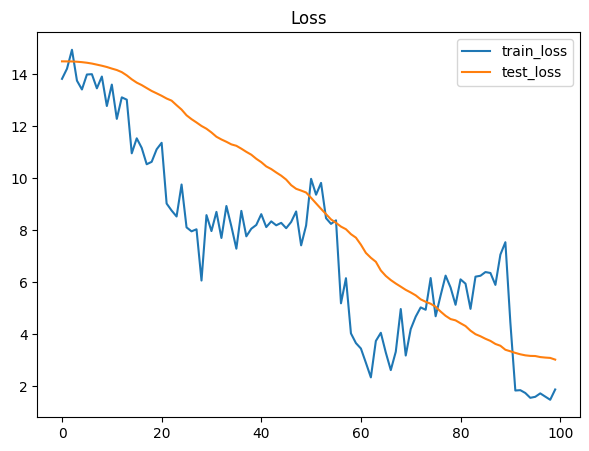

<Figure size 640x480 with 0 Axes>

In [15]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))
ax1.set_title('Loss')
#ax2.set_title('Accuracy')
for dataset in ('train','test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  #ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
#ax2.legend()
plt.show()
plt.clf()